In [1]:
%pylab inline
from astropy.table import Table
import numpy as np
import fitsio
import pickle
import numpy as np
from scipy.signal import savgol_filter

Populating the interactive namespace from numpy and matplotlib


In [2]:
outfile = './normalized_spectra.fits'

In [3]:
# read normalized fluxes, ivars
fluxes = fitsio.read(outfile, 'FLUX')
ivars = fitsio.read(outfile, 'IVAR')
wavelengths = fitsio.read(outfile, 'WAVE')
rest_loglams = fitsio.read(outfile, 'LOGLAMBDA')
qsocat = Table.read(outfile, 'QSOCAT')

In [4]:
def smooth(flux, n=31):
    """
    Smooths the noise from a given spectrum using the scipy function savgol_filter
    Args:
        flux : an array of the flux values for a single spectrum
    Options:
        n : 
    """
    return savgol_filter(flux, n, polyorder=3)

In [5]:
def plot_spectra(nums, fluxes, wavelengths=[], alpha=0.7, bin_size=0.0001):
    """
    Plots NUMS spectra from FLUXES
    Args:
        nums : an array specifying which spectra to plot
        fluxes : a 2D array where each element is an array of the flux values for a given spectrum
    Options:
        alpha
        bin_size
    """
    if nums == 0:
        return
    spectra = np.random.choice(np.arange(fluxes.shape[0]), size=nums)
    num_xbins = len(fluxes[0])
    if len(wavelengths) > 0:
        xs = wavelengths
    else:
        xs = np.arange(num_xbins)*bin_size
    for i in spectra:
        #- smooths out the ith spectrum
        smoothed = smooth(fluxes[i])
        plot(xs, smoothed, alpha=alpha)

27001


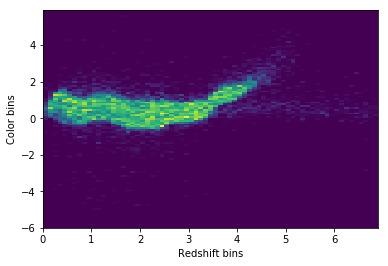

In [6]:
g_final = np.array(qsocat['PSFMAG'])[:,1]
r_final = np.array(qsocat['PSFMAG'])[:,2]
final_cr = g_final-r_final
plt.hist2d(x=qsocat['Z'], y=final_cr, bins=[np.arange(0,7,.1),np.arange(-6,6,.1)]);
plt.xlabel('Redshift bins');
plt.ylabel('Color bins');
print(len(qsocat))

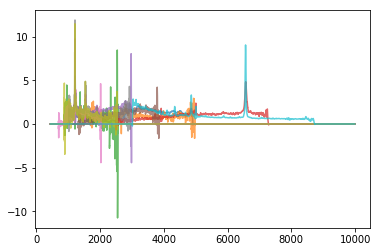

In [7]:
plot_spectra(10, fluxes, wavelengths=wavelengths)

In [8]:
def plot_chisq_dist(chisq_dist, hist=False, bins=None, binrange=None):
    """
    Plot the distribution of the chisq values
    Args:
        chisq_dist : an array of chi-sq values each corresponding to a spectrum
    Options:
        hist : choose whether to display the distribution as a histogram (True) or 
                in order of spectra (default=False)
    """
    if hist:
        pyplot.hist(chisq_dist, bins, binrange);
    else:
        plot(np.arange(len(chisq_dist)), chisq_dist);

In [9]:
def chisq_per_spectrum(num, fluxes, ivars):
    '''
    Generates the chisquared value for a particular SPECTRUM in FLUXES
    
    Args:
        spectrum : a given spectrum
        fluxes : a 2D array of processed spectra
        ivars : a 2D array of corresponding processed ivars
    '''
    spectrum = fluxes[num]
    ivar_arr = ivars[num]
    start_idx = np.flatnonzero(spectrum)[0]
    end_idx = np.flatnonzero(spectrum)[-1]
    
    f_means = np.average(fluxes, weights=ivars, axis=0)
    chi_terms = (spectrum-f_means)**2 * ivar_arr
    chi_stat = sum(chi_terms)
    return chi_stat

In [10]:
def calc_chisq_dist(fluxes, ivars):
    """
    Generates an array of chisquared stats for each spectrum in FLUXES
    
    Args:
        fluxes : a 2D array of processed spectra
        ivars : a corresponding 2D array of processed ivars
    """
    # TODO: np.ma.average?
    mean_flux = np.average(fluxes, weights=ivars, axis=0)
    chi_dist = np.sum((fluxes - mean_flux)**2 * ivars, axis=1)
    return chi_dist

In [11]:
def remove_outliers(fluxes, ivars, chisq_dist, cutoff_val, qsocat):
    """
    Removes spectra from fluxes with above CUTOFF_VAL of chi-squared values
    Returns 2D arrays (fluxes and ivars) without those outlier spectra and a new chi_sq dist
    Args:
        fluxes : a 2D array of processed spectra
        ivars : a corresponding 2D array of processed ivars
        chisq_dist : a distribution of the chi-squared statistics for each spectrum
                     corresponding to the fluxes and ivars arrays
        cutoff_val : the chisq_stat value above which poor spectra are removed
        qsocat : a quasar catalog of the spectra recorded in fluxes
    """
    #- TODO: Removes any ivars with < 80% zero values over the relevant wavelength range
    
    #- Determines which of the spectra are beyond the cutoff
    outlier_bools = chisq_dist >= cutoff_val
    outlier_nums = chisq_dist[outlier_bools]
    
    print('removing {} bad spectra with chi-sq values > {:.3f}'.format(len(outlier_nums), cutoff_val))
    
    #- Removes the outliers from fluxes, ivars, qsocat
    fluxes = fluxes[~outlier_bools]
    ivars_no_outliers = ivars[~outlier_bools]
    new_qsocat = qsocat[~outlier_bools]
    
    new_dist = calc_chisq_dist(fluxes, ivars_no_outliers)
    
    return np.array(fluxes), np.array(ivars_no_outliers), new_dist, new_qsocat

In [12]:
def outlier_detection(fluxes, ivars, qsocat, rest_loglams, wavelengths):
    """
    Iterates over fluxes and ivars until all outliers removed (when all outliers are within 2SD of the mean)
    Args:
        fluxes : a 2D array of processed spectra
        ivars : a corresponding 2D array of processed ivars
        qsocat : a quasar catalog of the spectra recorded in fluxes
    Options:
        percentile_cutoff : the percent of poor spectra to remove (default=3)    
    """
    #- Generates an original chi-squared distribution, standard deviation and mean
    chisq_dist = calc_chisq_dist(fluxes, ivars)
    
    #- Removes any negative chisq values
    bad_chisq = chisq_dist < 0
    chisq_dist = chisq_dist[~bad_chisq]
    fluxes = fluxes[~bad_chisq]
    ivars = ivars[~bad_chisq]
    qsocat = qsocat[~bad_chisq]
    
    
    #- Define a cutoff function based on the distribution
    cutoff_func = lambda dist: 3*np.mean(dist)
    
    #- Run at least one iteration of removing outliers
    first_cutoff = cutoff_func(chisq_dist)
    orig_len = len(fluxes)
    fluxes, ivars, chisq_dist, qsocat = remove_outliers(fluxes, ivars, chisq_dist, first_cutoff, qsocat)

    count=1
    while (len(fluxes) < orig_len and count < 3):
        print('iteration {}'.format(count))
        fluxes, ivars, chisq_dist, qsocat = remove_outliers(fluxes, ivars, chisq_dist, cutoff_func(chisq_dist), qsocat)
        count += 1
        
    return fluxes, ivars, chisq_dist, qsocat, rest_loglams, wavelengths

In [13]:
def enough_obs(fluxes, ivars, qsocat, rest_loglams, wavelengths, min_spectra=50):
    """
    TODO: docstring
    """
    num_ivars_for_wavelength = np.sum(ivars>0, axis=0)
    nonzero_idx = num_ivars_for_wavelength > min_spectra
    fluxes = fluxes[:, nonzero_idx]
    ivars = ivars[:, nonzero_idx]
    rest_loglams = rest_loglams[nonzero_idx]
    wavelengths = wavelengths[nonzero_idx]
    
    return fluxes, ivars, qsocat, rest_loglams, wavelengths

In [14]:
min_per_lam=50

(27001, 13218)


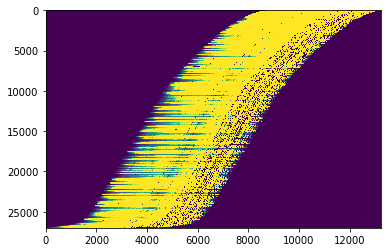

In [15]:
#- Removes wavelengths with < min_spectra nonzero observations
#- Note that this does NOT remove any spectra from qsocat
fluxes, ivars, qsocat, rest_loglams, wavelengths = enough_obs(fluxes, 
                                                              ivars, 
                                                              qsocat, 
                                                              rest_loglams, 
                                                              wavelengths, 
                                                              min_spectra=min_per_lam)
print(fluxes.shape)
imshow(ivars, aspect='auto', vmin=0, vmax=2);

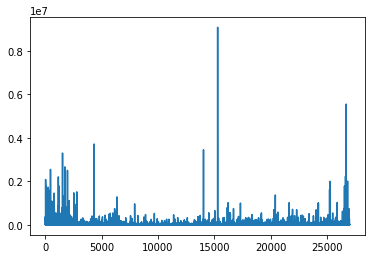

In [16]:
old_dist = calc_chisq_dist(fluxes, ivars)
plot_chisq_dist(old_dist)

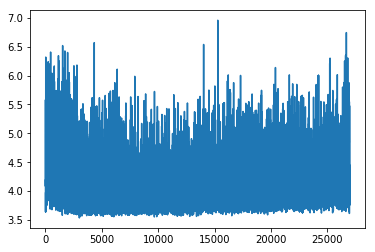

In [17]:
plot(np.arange(len(old_dist)), np.log10(old_dist));

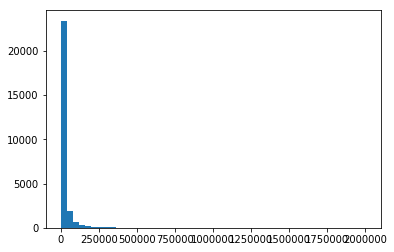

In [18]:
plot_chisq_dist(old_dist, hist=True, bins=50, binrange=(0,2*10**6));

In [19]:
%%time
new_f, new_i, new_dist, qsocat, rest_loglams, wavelengths = outlier_detection(fluxes, 
                                                                 ivars, 
                                                                 qsocat, 
                                                                 rest_loglams, 
                                                                 wavelengths)

removing 1414 bad spectra with chi-sq values > 93948.184
iteration 1
removing 1442 bad spectra with chi-sq values > 45830.129
iteration 2
removing 749 bad spectra with chi-sq values > 36585.789
CPU times: user 39.4 s, sys: 28.9 s, total: 1min 8s
Wall time: 1min 8s


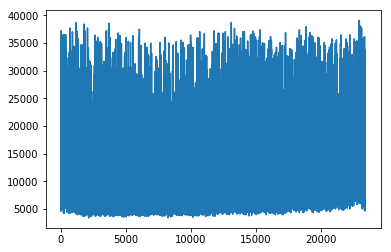

In [20]:
plot_chisq_dist(new_dist)

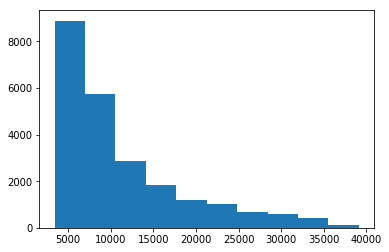

In [21]:
plot_chisq_dist(new_dist, hist=True)

In [22]:
print(new_f.shape)

(23396, 13218)


(23396, 12938)


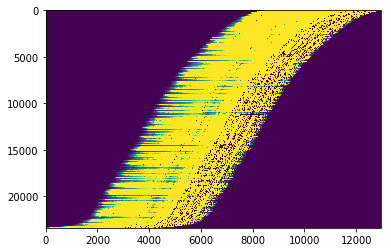

In [23]:
#- Removes wavelengths with < min_spectra nonzero observations
new_f, new_i, qsocat, new_restlams, new_waves = enough_obs(new_f, new_i, qsocat, rest_loglams, wavelengths, min_spectra=min_per_lam)
print(new_f.shape)
imshow(new_i, aspect='auto', vmin=0, vmax=2);

In [24]:
with open("./cleaned_spectra/fluxes_clean.pkl","wb") as file:
    pickle.dump(new_f,file)

with open("./cleaned_spectra/ivars_clean.pkl","wb") as file:
    pickle.dump(new_i,file)

with open("./cleaned_spectra/restlams_clean.pkl","wb") as file:
    pickle.dump(new_restlams,file)

with open("./cleaned_spectra/wavelengths_clean.pkl","wb") as file:
    pickle.dump(new_waves,file)

qsocat.write('./cleaned_spectra/qsocat_clean.fits', format='fits', overwrite=True)

#### Check that outlier detection has not removed the color balance in the dataset

In [25]:
with open("./cleaned_spectra/fluxes_clean.pkl", "rb") as file:
    fluxes = pickle.load(file)

qsocat_clean = Table.read('./cleaned_spectra/qsocat_clean.fits')

23396


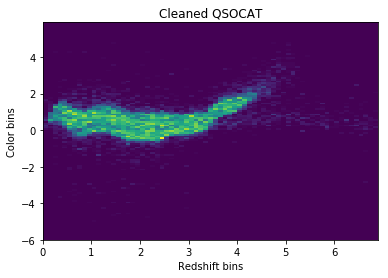

In [26]:
g_final = np.array(qsocat_clean['PSFMAG'])[:,1]
r_final = np.array(qsocat_clean['PSFMAG'])[:,2]
final_cr = g_final-r_final
plt.hist2d(x=qsocat_clean['Z'], y=final_cr, bins=[np.arange(0,7,.1),np.arange(-6,6,.1)]);
plt.xlabel('Redshift bins');
plt.ylabel('Color bins');
print(len(qsocat_clean))
plt.title('Cleaned QSOCAT');

23396


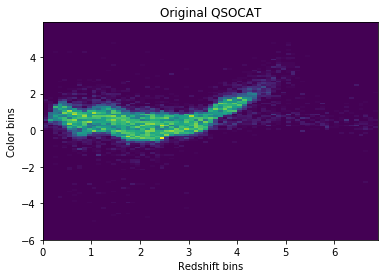

In [27]:
g_final = np.array(qsocat['PSFMAG'])[:,1]
r_final = np.array(qsocat['PSFMAG'])[:,2]
final_cr = g_final-r_final
plt.hist2d(x=qsocat['Z'], y=final_cr, bins=[np.arange(0,7,.1),np.arange(-6,6,.1)]);
plt.xlabel('Redshift bins');
plt.ylabel('Color bins');
print(len(qsocat))
plt.title('Original QSOCAT');